In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from nilearn.connectome import sym_matrix_to_vec
from scipy.stats import pearsonr
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from cmath import isinf
from utils_v import compute_target_score
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, MLP
from dev_losses import cauchy, rbf, gaussian_kernel, CustomSupCon, CustomContrastiveLoss
from losses import KernelizedSupCon

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat, input_dim_target, hidden_dim_feat, output_dim, dropout_rate):
        super(MLP, self).__init__()
        
        # Xavier initialization for feature MLP
        self.feat_mlp = nn.Sequential(
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.BatchNorm1d(hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        self.init_weights(self.feat_mlp)

        # Xavier initialization for target MLP
        self.target_mlp = nn.Sequential(
            nn.Linear(input_dim_target, output_dim)
        )
        self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x, y):
        features = self.feat_mlp(x)
        targets = self.target_mlp(y)
        features = nn.functional.normalize(features, p=2, dim=1)
        targets = nn.functional.normalize(targets, p=2, dim=1)
        return features, targets

In [19]:
def mirror_conn(matrix, regions, vecrorize_mat = True):
    """
    Flips the connectivity of specified regions within their hemispheres. Handles both single indices and lists of indices.
    
    :param matrix: The connectivity matrix.
    :param regions: A single index or a list of indices for the regions.
    :return: A 3D array of modified connectivity matrices. Each "slice" corresponds to the matrix after flipping each specified region.
    """
    if not isinstance(regions, list):
        regions = [regions]
    flipped_matrices = []
    
    for index in regions:
        new_matrix = matrix.copy()
        hemisphere_size = matrix.shape[0] // 2
        is_left_hemisphere = index < hemisphere_size
        opposite_index = index + (-1 if is_left_hemisphere else 1) * hemisphere_size
        
        # Flip connectivity for the specified region within its hemisphere
        if is_left_hemisphere:
            new_matrix[index, :hemisphere_size], new_matrix[opposite_index, :hemisphere_size] = \
                new_matrix[opposite_index, :hemisphere_size].copy(), new_matrix[index, :hemisphere_size].copy()
            
        else:
            new_matrix[index, hemisphere_size:], new_matrix[opposite_index, hemisphere_size:] = \
                new_matrix[opposite_index, hemisphere_size:].copy(), new_matrix[index, hemisphere_size:].copy()
            
        if vecrorize_mat:
            new_matrix = sym_matrix_to_vec(new_matrix, discard_diagonal = True)
        flipped_matrices.append(new_matrix)
        
    return np.array(flipped_matrices)

In [20]:
def flip_edge_between_regions(matrix, regions, vectorize_mat=True):
    """
    Flips the connectivity edge between two specified regions across hemispheres.
    Handles pairs of regions or lists of pairs of regions.
    
    :param matrix: The connectivity matrix.
    :param regions: A pair of indices or a list of pairs of indices for the regions.
    :param vectorize_mat: Whether to vectorize the output matrices.
    :return: A 3D array of modified connectivity matrices. Each "slice" corresponds to the matrix after flipping the edge for each specified pair.
    """
    if not isinstance(regions[0], list):
        regions = [regions]
    flipped_matrices = []
    
    for pair in regions:
        new_matrix = matrix.copy()
        hemisphere_size = matrix.shape[0] // 2
        
        # Determine the indices for flipping
        for index1, index2 in [pair]:
            is_left_hemisphere1 = index1 < hemisphere_size
            is_left_hemisphere2 = index2 < hemisphere_size
            
            # Calculate the opposite indices in the other hemisphere
            opposite_index1 = index1 + (-1 if is_left_hemisphere1 else 1) * hemisphere_size
            opposite_index2 = index2 + (-1 if is_left_hemisphere2 else 1) * hemisphere_size
            
            # Flip the connectivity edge between the specified pairs across hemispheres
            new_matrix[index1, opposite_index2], new_matrix[index2, opposite_index1] = \
                new_matrix[index2, opposite_index1], new_matrix[index1, opposite_index2]
            new_matrix[opposite_index2, index1], new_matrix[opposite_index1, index2] = \
                new_matrix[opposite_index1, index2], new_matrix[opposite_index2, index1]
        
        if vectorize_mat:
            # Assuming 'sym_matrix_to_vec' is a function you have that vectorizes a symmetric matrix
            new_matrix = sym_matrix_to_vec(new_matrix, discard_diagonal=True)
        
        flipped_matrices.append(new_matrix)
        
    return np.array(flipped_matrices)

In [21]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, transform = None, train=True, train_size = 0.8, test_size=None, test_site = None, regions = None, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        # Load the entire dataset
        features = np.load(path_feat)
        participant_data = pd.read_csv(path_target)
        targets = np.expand_dims(participant_data[target_name].values, axis = 1)
        

        # Split the dataset into training and test sets
        if test_site is None:
            train_indices, test_indices = train_test_split(np.arange(len(features)), 
                                                       train_size = train_size,
                                                       test_size=test_size,                
                                                       random_state=random_state)
        else:
            test_indices = participant_data.index[participant_data['dataset'] == test_site].values
            train_indices = np.delete(np.arange(len(features)), test_indices)
        
        if train:
            selected_indices = train_indices
        else:
            selected_indices = test_indices
        
        # Select the subset of data for the current mode (train/test)
        features = features[selected_indices]
        targets = targets[selected_indices]
        

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if (train and transform is not None):
            # augmentation only in training mode
            if transform != "copy":
                augmented_features = np.array([self.transform(sample, regions = regions) for sample in features])

                self.n_views = self.n_views + augmented_features.shape[1]
                self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
                for sub in range(self.n_sub):
                    self.features[sub, 0, :] = vectorized_feat[sub]
                    self.features[sub, 1:, :] = augmented_features[sub]
            else:
                self.features = np.repeat(np.expand_dims(vectorized_feat, axis = 1), 2, axis=1)
        else:
            self.features = np.expand_dims(vectorized_feat, axis = 1)
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets
    

In [22]:
def standardize_dataset(dataset):
    all_features_flat = torch.cat([dataset[i][0].view(-1, dataset[i][0].shape[-1]) for i in range(len(dataset))], dim=0)
    all_targets = torch.cat([dataset[i][1].unsqueeze(0) for i in range(len(dataset))], dim=0)
    
    features_mean = all_features_flat.mean(dim=0)
    features_std = all_features_flat.std(dim=0)
    
    features_std[features_std == 0] = 1
    standardized_features_list = []
    
    for i in range(len(dataset)):
        features = dataset[i][0].view(-1, dataset[i][0].shape[-1])
        standardized_features = (features - features_mean) / features_std
        standardized_features_list.append(standardized_features.view(dataset[i][0].shape))
    
    standardized_features = torch.stack(standardized_features_list)
    
    standardized_dataset = TensorDataset(standardized_features, all_targets)
    
    return standardized_dataset

In [23]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

def rbf(x, krnl_sigma):
        x = x - x.T
        return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

In [24]:
!pwd

/gpfs3/well/margulies/users/cpy397/contrastive-learning


In [25]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str, temperature: float=0.07, contrast_mode: str='all',
                 base_temperature: float=0.07, krnl_sigma: float = 1., kernel: callable=None, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        contrast_count = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma = self.krnl_sigma)     
        
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*anchor_count, device=device).view(-1, 1),
            0
        )
        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))


        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()
    

In [80]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
# the rest is arbitrary
hidden_dim_feat = 1000
input_dim_target = 1
output_dim = 2
num_epochs = 100

lr = 0.01 # too low values return nan loss
kernel = cauchy
batch_size = 30 # too low values return nan loss
dropout_rate = 0
weight_decay = 0

In [81]:
train_dataset = MatData("matrices.npy", "participants.csv", "age", transform = None,test_site = "LA5c")


In [82]:
test_dataset = MatData("matrices.npy", "participants.csv", "age", train=False, test_site = "LA5c")


In [83]:
standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

In [84]:
standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=False)

In [85]:
# torch.cuda.empty_cache()
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, output_dim, dropout_rate).to(device)
criterion_pft = KernelizedSupCon(method='expw', temperature=0.03, base_temperature=0.07, kernel=kernel, krnl_sigma = 1, contrast_mode = 'all')
criterion_ptt = KernelizedSupCon(method='expw', temperature=0.03, base_temperature=0.07, kernel=kernel, krnl_sigma = 1, contrast_mode = 'all')

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        bsz = targets.shape[0]
        n_views = features.shape[1]
        n_feat = features.shape[-1]
        
        features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
        features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]
        
        optimizer.zero_grad()
        out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0)) # ([bsz*5, 1], [bsz*5, 1])
        
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]
        
        loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])
        
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]
        loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])
    
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')


Epoch 0 | Mean Loss 4.10104379830537
Epoch 1 | Mean Loss 3.00213325465167
Epoch 2 | Mean Loss 2.864960608658967
Epoch 3 | Mean Loss 2.8474227631533586
Epoch 4 | Mean Loss 2.845810965255455
Epoch 5 | Mean Loss 2.8445033806341664
Epoch 6 | Mean Loss 2.8444645272360907
Epoch 7 | Mean Loss 2.8421713555300676
Epoch 8 | Mean Loss 2.8406476886184127
Epoch 9 | Mean Loss 2.8384611474143133
Epoch 10 | Mean Loss 2.834229504620587
Epoch 11 | Mean Loss 2.8267456116499723
Epoch 12 | Mean Loss 2.8075033823649087
Epoch 13 | Mean Loss 2.6920737557941012
Epoch 14 | Mean Loss 2.563677514040912
Epoch 15 | Mean Loss 2.5614390152472035
Epoch 16 | Mean Loss 2.565757393836975
Epoch 17 | Mean Loss 2.5606619163795754
Epoch 18 | Mean Loss 2.5698984419858015
Epoch 19 | Mean Loss 2.561295995005855
Epoch 20 | Mean Loss 2.5437033617938005
Epoch 21 | Mean Loss 2.550403025415209
Epoch 22 | Mean Loss 2.5580538864488953
Epoch 23 | Mean Loss 2.573895639843411
Epoch 24 | Mean Loss 2.561052198763247
Epoch 25 | Mean Loss 2.

## Evaluation

In [86]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import multiprocessing

@torch.no_grad()
def gather_feats_targets(model, dataloader, device):
    features = []
    targets = []

    model.eval()
    for idx, (feat, target) in enumerate(dataloader):
        if len(feat.shape) > 2:
            feat = feat[:, 0, :]
        feat = feat.to(device)
        target = target.to(device)
        out_feat, out_target= model(feat, target)
        features.append(out_feat)
        targets.append(target[:, 0])
    
    return torch.cat(features, 0).cpu().numpy(), torch.cat(targets, 0).cpu().numpy()

@torch.no_grad()
def estimate_age(model, train_loader, test_loader, device):
    age_estimator = AgeEstimator()
    X_train, y_train = gather_feats_targets(model, train_loader, device)
    age_estimator.fit(X_train, y_train)
    y_pred_train = age_estimator.predict(X_train)
    X_test, y_test = gather_feats_targets(model, test_loader, device)
    y_pred_test = age_estimator.predict(X_test)
    return y_train, y_test, y_pred_train, y_pred_test

@torch.no_grad()
def compute_age_mae_r2(model, train_loader, test_loader, device): # test_int, test_ext, opts
    age_estimator = AgeEstimator()

    print("Training age estimator")
    train_X, train_y = gather_feats_targets(model, train_loader, device)
    mae_train, r2_train = age_estimator.fit(train_X, train_y)
    X_test, y_test = gather_feats_targets(model, test_loader, device)
    #ext_X, ext_y = gather_age_feats(model, test_ext, opts)
    mae_test = age_estimator.score(X_test, y_test)
    r2_test = age_estimator.r2(X_test, y_test)
    # mae_ext = age_estimator.score(ext_X, ext_y)

    return mae_train, r2_train, mae_test, r2_test # mae, r2 for train and test

class AgeEstimator(BaseEstimator):
    """ Define the age estimator on latent space network features.
    """
    def __init__(self):
        n_jobs = multiprocessing.cpu_count()
        self.age_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10.**np.arange(-2, 3)}, cv=5,
            scoring="r2", n_jobs=n_jobs)

    def fit(self, X, y):
        self.age_estimator.fit(X, y)
        return self.score(X, y), self.r2(X, y)

    def predict(self, X):
        y_pred = self.age_estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return mean_absolute_percentage_error(y, y_pred)
    
    def r2(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return r2_score(y, y_pred)

In [87]:
age_train, age_test, age_pred_train, age_pred_test = estimate_age(model, std_train_loader, std_test_loader, device)

X_train, y_train = gather_feats_targets(model, std_train_loader, device)
X_test, y_test = gather_feats_targets(model, std_test_loader, device)

df_train = pd.DataFrame({"Y_Train":age_train, "Y_Train_Pred":age_pred_train})
df_test = pd.DataFrame({"Y_Test": age_test, "Y_Test_Pred":age_pred_test})

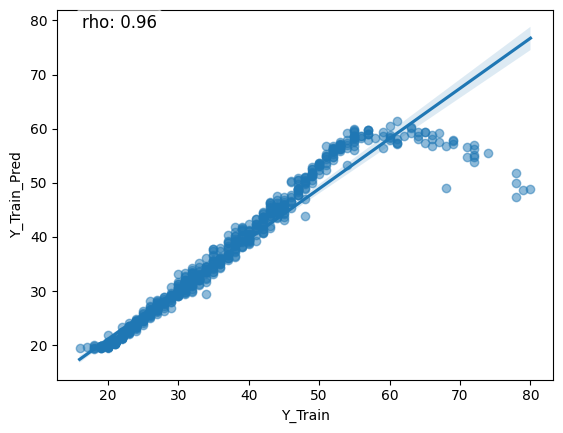

In [88]:

corr, _ = pearsonr(df_train['Y_Train'], df_train['Y_Train_Pred'])
corr_text = f'rho: {corr:.2f}'
sns.regplot(x='Y_Train', y='Y_Train_Pred', data=df_train, scatter_kws={'alpha':0.5})
plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
plt.show()

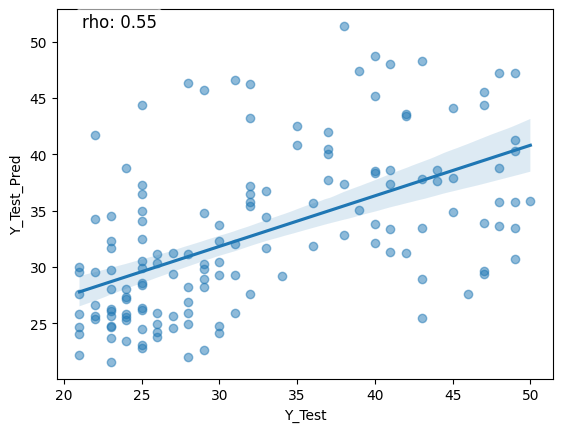

In [89]:
corr, _ = pearsonr(df_test['Y_Test'], df_test['Y_Test_Pred'])
corr_text = f'rho: {corr:.2f}'
sns.regplot(x='Y_Test', y='Y_Test_Pred', data=df_test, scatter_kws={'alpha':0.5})
plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
plt.show()

In [90]:
mape_train, r2_train, mape_test, r2_test = compute_age_mae_r2(model, std_train_loader, std_test_loader, device)
print(f"Train Age MAPE: {mape_train}, Test Age MAPE: {mape_test}.")
print(f"Train Age R2: {r2_train}, Test Age R2: {r2_test}.")

Training age estimator
Train Age MAPE: 0.03658764809370041, Test Age MAPE: 0.18452905118465424.
Train Age R2: 0.929795345982753, Test Age R2: 0.23565704271021848.


## Testing

In [45]:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# features = torch.vstack([test_dataset[i][0] for i in range(len(test_loader))])
# targets = torch.vstack([test_dataset[i][1] for i in range(len(test_loader))])
# features_mean, features_std, targets_mean, targets_std = compute_global_stats(test_dataset)
# standardized_features = (features - features_mean) / features_std
# standardized_targets = (targets - targets_mean) / targets_std
# standardized_test_dataset = TensorDataset(standardized_features, standardized_targets)
# test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [47]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_test_loader):
        bsz = targets.shape[0]
        n_views = 1
        n_feat = features.shape[-1]
        
        if len(features.shape) > 2:
            n_views = features.shape[1]
            features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
        features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]

        out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0))   
        
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]
        
        loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])
        
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]
        
        loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])
        
        emb_features.append(out_feat[:, 0, :])
        emb_targets.append(out_target[:, 0, :])
        
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   2.78


In [48]:
emb_features = torch.row_stack(emb_features).cpu()

In [49]:
emb_targets = torch.row_stack(emb_targets).cpu()

In [50]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [51]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [52]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

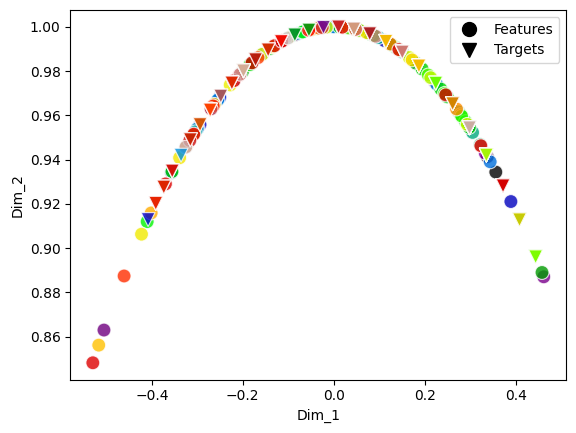

In [91]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
# plt.xlim(-0.1, 0.1)
# plt.ylim(0.98, 1)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])